# Exploratory Data Analysis (EDA)
## Legal Document Tagging System

This notebook analyzes the extracted document data to understand:
- Tag distributions and class imbalance
- Text length characteristics
- Multi-label complexity
- Missing data patterns

**Run this after Phase 2 (document extraction) and before Phase 3 (feature processing)**

## Setup

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import ast

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

In [28]:
df = pd.read_csv('../processed/documents_all.csv')
print(f"Total documents: {len(df)}")
print(f"Total cases: {df['case_id'].nunique()}")
print(f"\nColumns: {list(df.columns)}")
df.head()

Total documents: 11546
Total cases: 1230

Columns: ['case_id', 'doc_id', 'title', 'source', 'text', 'document_type', 'party_types']


,case_id,doc_id,title,source,text,document_type,party_types
0,case_10002,case_10002_doc_0,NaN,NaN,NaN,NaN,NaN
1,case_10002,case_10002_doc_1,Docket [MA State Court],NaN,MAS-20020121 Commonwealth of Massachusetts 0...,Docket,['Court']
2,case_10002,case_10002_doc_2,Defendants' Memorandum in Support of Their Mot...,NaN,UNITED STATES DISTRICT COURT\nDISTRICT OF MASS...,Pleading / Motion / Brief,['Defendant']
3,case_10002,case_10002_doc_3,Defendants County of Suffolk and Angelo Rao's ...,NaN,UNITED STATES DISTRICT COURT \nDISTRICT OF MAS...,Pleading / Motion / Brief,['Defendant']
4,case_10002,case_10002_doc_4,Memorandum and Order on Individuals Defendants...,Google Scholar,379 F.Supp.2d 138 (2005)\nAntonia DETOLEDO and...,Order/Opinion,['Court']


## 1. Missing Data Analysis

In [29]:
print("=== Missing Data Analysis ===")
missing = df.isnull().sum()
print(missing[missing > 0])

# Documents with missing tags
missing_doctype = df['document_type'].isnull().sum()
missing_party = df['party_types'].isnull().sum()
print(f"\nDocuments missing document_type: {missing_doctype} ({missing_doctype/len(df)*100:.1f}%)")
print(f"Documents missing party_types: {missing_party} ({missing_party/len(df)*100:.1f}%)")

=== Missing Data Analysis ===
title            1435
source           3067
text             2264
document_type    1453
party_types      1923
dtype: int64

Documents missing document_type: 1453 (12.6%)
Documents missing party_types: 1923 (16.7%)


## 2. Document Type Distribution

=== Document Type Distribution ===
document_type
Order/Opinion                                    4401
Pleading / Motion / Brief                        2292
Complaint                                        1159
Docket                                            714
Monitor/Expert/Receiver Report                    401
Settlement Agreement                              371
Other                                             165
Findings Letter/Report                            121
Correspondence                                    116
Press Release                                      67
Notice of Investigation or Suit/Demand Letter      63
Transcript                                         51
Declaration/Affidavit                              44
Internal memorandum                                37
Magistrate Report/Recommendation                   33
Statement of Interest (DOJ)                        18
Justification Memo                                 16
Statute/Ordinance/Regulation     

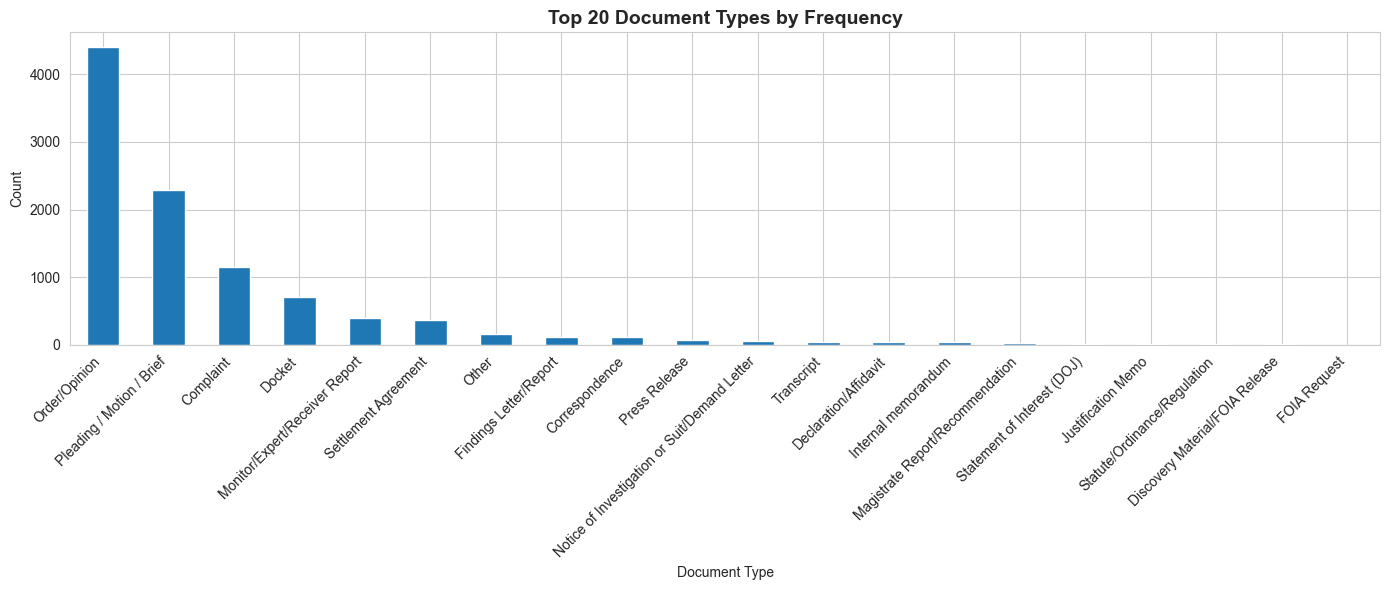


Most common: 4401 (38.1%)
Least common: 1
Imbalance ratio: 4401.0x


In [30]:
print("=== Document Type Distribution ===")
doctype_counts = df['document_type'].value_counts()
print(doctype_counts.head(20))

plt.figure(figsize=(14, 6))
doctype_counts.head(20).plot(kind='bar')
plt.title('Top 20 Document Types by Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Document Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check for imbalance
print(f"\nMost common: {doctype_counts.iloc[0]} ({doctype_counts.iloc[0]/len(df)*100:.1f}%)")
print(f"Least common: {doctype_counts.iloc[-1]}")
print(f"Imbalance ratio: {doctype_counts.iloc[0] / doctype_counts.iloc[-1]:.1f}x")

## 3. Party Types Distribution

=== Party Types Distribution ===
Unique party types: 12

Top 15 party types:
  Court: 5016
  Plaintiff: 3279
  Defendant: 1743
  Monitor/Master: 290
  Amicus Curiae: 148
  Receiver: 114
  Plaintiff-Intervenor: 105
  Expert: 75
  Defendant-Intervenor: 50
  Other/Unknown: 46
  Mediator: 4
  Administrative tribunal: 1


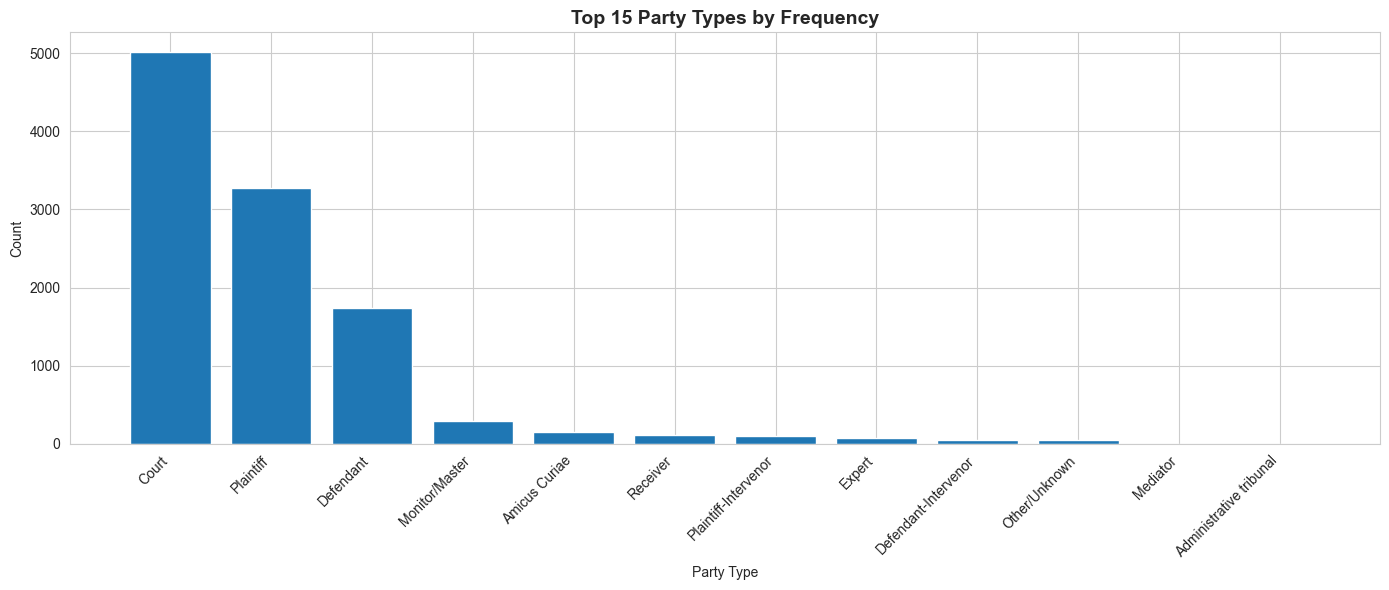

In [5]:
print("=== Party Types Distribution ===")

# Parse party_types (stored as string representation of list)
def parse_party_types(val):
    if pd.isna(val) or val == 'None':
        return []
    try:
        return ast.literal_eval(val) if val else []
    except:
        return []

df['party_list'] = df['party_types'].apply(parse_party_types)

# Count individual party types
all_parties = []
for parties in df['party_list']:
    all_parties.extend(parties)

party_counts = Counter(all_parties)
print(f"Unique party types: {len(party_counts)}")
print("\nTop 15 party types:")
for party, count in party_counts.most_common(15):
    print(f"  {party}: {count}")

# Visualize
plt.figure(figsize=(14, 6))
top_parties = dict(party_counts.most_common(15))
plt.bar(top_parties.keys(), top_parties.values())
plt.title('Top 15 Party Types by Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Party Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Party Type Co-occurrence Analysis

In [6]:
print("=== Party Type Co-occurrence ===")

# Find documents with multiple party types
multi_party = df[df['party_list'].apply(len) > 1]
print(f"Documents with multiple party types: {len(multi_party)} ({len(multi_party)/len(df)*100:.1f}%)")

# Most common pairs
from itertools import combinations
pairs = []
for parties in multi_party['party_list']:
    if len(parties) >= 2:
        pairs.extend(list(combinations(sorted(parties), 2)))

pair_counts = Counter(pairs)
print("\nTop 10 party type pairs:")
for pair, count in pair_counts.most_common(10):
    print(f"  {pair[0]} + {pair[1]}: {count}")

=== Party Type Co-occurrence ===
Documents with multiple party types: 894 (7.7%)

Top 10 party type pairs:
  Defendant + Plaintiff: 808
  Court + Plaintiff: 350
  Court + Defendant: 338
  Court + Monitor/Master: 20
  Expert + Plaintiff: 18
  Plaintiff + Plaintiff-Intervenor: 11
  Defendant + Expert: 10
  Defendant + Plaintiff-Intervenor: 9
  Amicus Curiae + Plaintiff: 8
  Plaintiff + Receiver: 5


## 5. Text Length Analysis

In [31]:
print("=== Text Length Analysis ===")

# Calculate lengths
df['title_len'] = df['title'].fillna('').astype(str).str.len()
df['source_len'] = df['source'].fillna('').astype(str).str.len()
df['text_len'] = df['text'].fillna('').astype(str).str.len()
df['combined_len'] = df['title_len'] + df['source_len'] + df['text_len']

# Statistics
print("Length statistics:")
print(df[['title_len', 'source_len', 'text_len', 'combined_len']].describe())

=== Text Length Analysis ===
Length statistics:
          title_len    source_len      text_len  combined_len
count  11546.000000  11546.000000  11546.000000  11546.000000
mean      38.769444     22.667677   6418.577516   6480.014637
std       42.929703     21.877952   4322.254303   4333.934648
min        0.000000      0.000000      0.000000      0.000000
25%        7.000000      0.000000   1265.500000   1322.500000
50%       23.000000     14.000000  10000.000000  10014.000000
75%       59.000000     49.000000  10000.000000  10063.000000
max      443.000000     80.000000  10000.000000  10450.000000


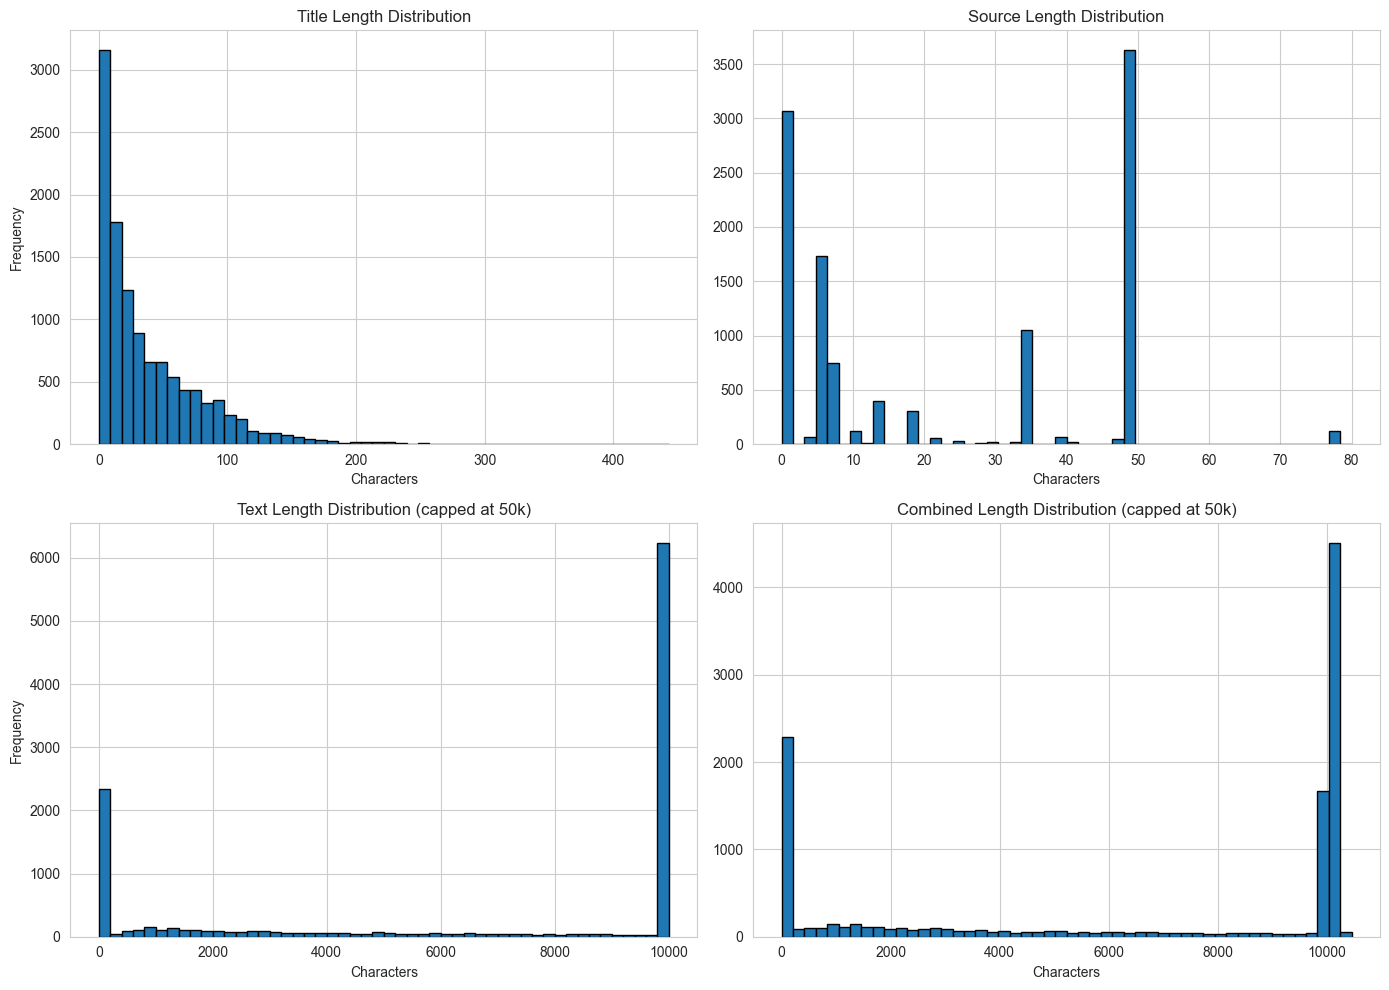


Documents > 10,000 chars: 0 (0.0%)
Documents > 50,000 chars: 0 (0.0%)


In [32]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(df['title_len'], bins=50, edgecolor='black')
axes[0, 0].set_title('Title Length Distribution')
axes[0, 0].set_xlabel('Characters')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df['source_len'], bins=50, edgecolor='black')
axes[0, 1].set_title('Source Length Distribution')
axes[0, 1].set_xlabel('Characters')

axes[1, 0].hist(df['text_len'].clip(upper=50000), bins=50, edgecolor='black')
axes[1, 0].set_title('Text Length Distribution (capped at 50k)')
axes[1, 0].set_xlabel('Characters')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(df['combined_len'].clip(upper=50000), bins=50, edgecolor='black')
axes[1, 1].set_title('Combined Length Distribution (capped at 50k)')
axes[1, 1].set_xlabel('Characters')

plt.tight_layout()
plt.show()

# Check for very long documents
print(f"\nDocuments > 10,000 chars: {(df['text_len'] > 10000).sum()} ({(df['text_len'] > 10000).sum()/len(df)*100:.1f}%)")
print(f"Documents > 50,000 chars: {(df['text_len'] > 50000).sum()} ({(df['text_len'] > 50000).sum()/len(df)*100:.1f}%)")

## 6. Documents per Case

=== Documents per Case ===
Documents per case statistics:
count    1230.000000
mean        9.386992
std        32.233937
min         1.000000
25%         3.000000
50%         6.000000
75%        10.000000
max      1075.000000
dtype: float64


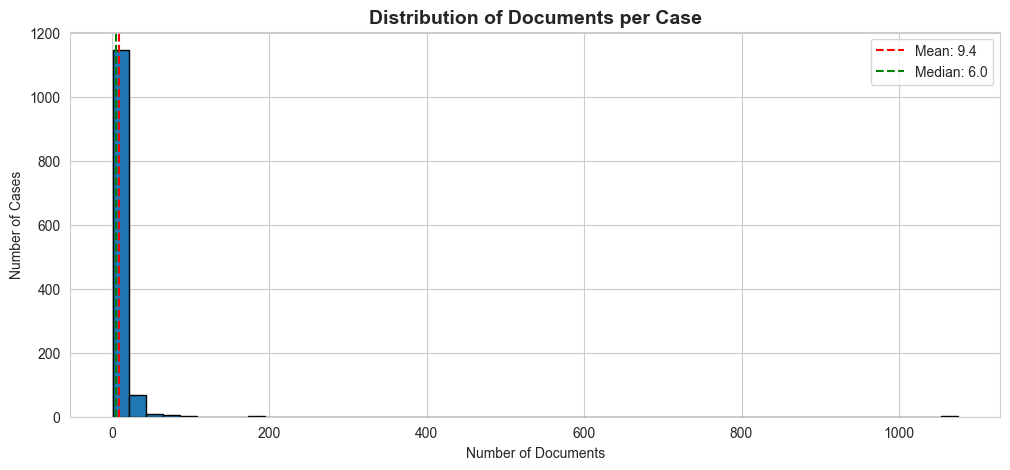

In [9]:
print("=== Documents per Case ===")

docs_per_case = df.groupby('case_id').size()
print("Documents per case statistics:")
print(docs_per_case.describe())

plt.figure(figsize=(12, 5))
plt.hist(docs_per_case, bins=50, edgecolor='black')
plt.title('Distribution of Documents per Case', fontsize=14, fontweight='bold')
plt.xlabel('Number of Documents')
plt.ylabel('Number of Cases')
plt.axvline(docs_per_case.mean(), color='red', linestyle='--', label=f'Mean: {docs_per_case.mean():.1f}')
plt.axvline(docs_per_case.median(), color='green', linestyle='--', label=f'Median: {docs_per_case.median():.1f}')
plt.legend()
plt.show()

## 7. Key Insights Summary

In [10]:
print("=" * 60)
print("KEY INSIGHTS FOR MODEL DESIGN")
print("=" * 60)

# Class imbalance
max_class_ratio = doctype_counts.iloc[0] / doctype_counts.iloc[-1]
if max_class_ratio > 10:
    print(f"\n⚠️  HIGH CLASS IMBALANCE detected (ratio: {max_class_ratio:.1f}x)")
    print("   → Consider: class weights, stratified sampling, or SMOTE")
else:
    print(f"\n✅ Class balance is reasonable (ratio: {max_class_ratio:.1f}x)")

# Text length
median_text_len = df['text_len'].median()
p95_text_len = df['text_len'].quantile(0.95)
if p95_text_len > 20000:
    print(f"\n⚠️  LONG DOCUMENTS detected (95th percentile: {p95_text_len:.0f} chars)")
    print(f"   → Current truncation at 10,000 chars will affect {(df['text_len'] > 10000).sum()} docs")
    print(f"   → Consider: increasing MAX_TEXT_LENGTH or using document summarization")
else:
    print(f"\n✅ Document lengths are manageable (95th percentile: {p95_text_len:.0f} chars)")

# Multi-label complexity
avg_parties = df['party_list'].apply(len).mean()
print(f"\n📊 Average party types per document: {avg_parties:.2f}")
if avg_parties > 2:
    print("   → Multi-label classification will be complex")
else:
    print("   → Multi-label classification complexity is moderate")

# Missing data
if missing_doctype > len(df) * 0.1:
    print(f"\n⚠️  HIGH MISSING TAG RATE: {missing_doctype/len(df)*100:.1f}% documents missing document_type")
    print("   → May significantly reduce training set size")
else:
    print(f"\n✅ Missing tag rate is acceptable: {missing_doctype/len(df)*100:.1f}%")

print("\n" + "=" * 60)
print("✅ EDA Complete! Use these insights to configure feature processing.")
print("=" * 60)

KEY INSIGHTS FOR MODEL DESIGN

⚠️  HIGH CLASS IMBALANCE detected (ratio: 4401.0x)
   → Consider: class weights, stratified sampling, or SMOTE

✅ Document lengths are manageable (95th percentile: 10000 chars)

📊 Average party types per document: 0.94
   → Multi-label classification complexity is moderate

⚠️  HIGH MISSING TAG RATE: 12.6% documents missing document_type
   → May significantly reduce training set size

✅ EDA Complete! Use these insights to configure feature processing.
